# Exercício 6.9

In [1]:
import random
from operator import add, sub
import gym
from gym import spaces

# def _remap_direction(state, direction, tuple_space):
#     assert isinstance(direction, tuple) and isinstance(state, tuple)
#     assert isinstance(tuple_space, spaces.Tuple)
#     return tuple(
#         s_i + d_i if s_i + d_i in space else s_i - d_i
#         for s_i, d_i, space in zip(state, direction, tuple_space))

def _clip_to_space(state, tuple_space):
    assert isinstance(state, tuple) and isinstance(tuple_space, spaces.Tuple)
    return tuple(min(max(0, s_i), space.n-1) for s_i, space in zip(state, tuple_space))

def addt(a,b):
    return tuple(map(add, a, b))

def subt(a,b):
    return tuple(map(sub, a, b))


class WindyGridworldEnv(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Tuple((spaces.Discrete(7), spaces.Discrete(10)))
        self.action_space = spaces.Discrete(4)
        self.action_effect = [
            (-1,0), 
            (1,0), 
            (0,-1), 
            (0,1)
        ]
        self.column_wind = [0,0,0,1,1,1,2,2,1,0]
        self.start = (3, 0)
        self.goal = (3, 7)
        self.state = None
        
    def reset(self):
        self.state = self.start
        return self.state
        
    def step(self, action):
        assert action in self.action_space
        wind = self.column_wind[self.state[1]]
        direction = addt(self.action_effect[action], (-wind, 0))
        result = addt(self.state, direction)
        self.state = state = _clip_to_space(result, self.observation_space)

        done = state == self.goal
        return state, -1, done, {}

    def render(self):
        pass
    
    def close(self):
        pass
    
    def seed(self):
        pass
    

class WindyGridworldKingsMovesEnv(WindyGridworldEnv):
    def __init__(self, noop=False):
        super().__init__()
        self.action_effect.extend([
            (-1,-1),
            (-1,1),
            (1,-1),
            (1,1)
        ])
        if noop:
            self.action_effect.append((0,0))
        self.action_space = spaces.Discrete(len(self.action_effect))

In [2]:
env = WindyGridworldEnv()
obs = env.reset()
print(env.step(0))

((2, 0), -1, False, {})


In [3]:
from collections import defaultdict

def sarsa(env, timesteps, alpha=0.5, epsilon=0.1, gamma=1.0):
    qval = defaultdict(lambda: 0)
    def get_action(state):
        # epsilon-greedy action selection
        if random.random() > epsilon:
            return max(range(env.action_space.n), key=lambda a: qval[state, a])
        else:
            return random.randrange(env.action_space.n)
    
    done, episodes, total_episodes = True, [], -1
    for timestep in range(timesteps):
        if done:
            state = env.reset()
            action = get_action(state)
            total_episodes += 1
        episodes.append(total_episodes)

        next_state, rew, done, _ = env.step(action)
        next_action = get_action(next_state)
        
        qval[state, action] = qval[state, action] + alpha*(
            rew + gamma*(not done)*qval[next_state, next_action] - qval[state, action])
        state, action = next_state, next_action
        
    return qval, episodes

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_episodes_x_timesteps(episodes):
    plt.plot(episodes)
    plt.xlabel('timesteps')
    plt.ylabel('episodes')
    plt.show()

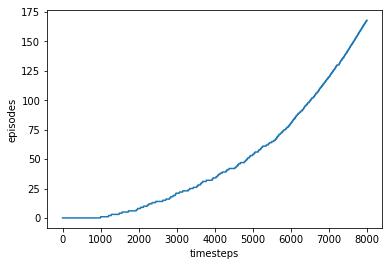

CPU times: user 213 ms, sys: 42.5 ms, total: 255 ms
Wall time: 366 ms


In [5]:
%%time
q_val, episodes = sarsa(WindyGridworldEnv(), 8000)
plot_episodes_x_timesteps(episodes)

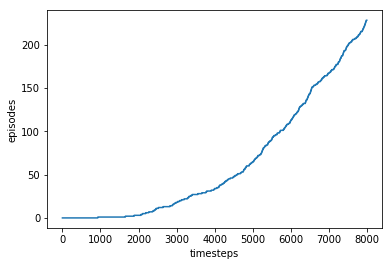

CPU times: user 158 ms, sys: 14.4 ms, total: 172 ms
Wall time: 173 ms


In [6]:
%%time
q_val, episodes = sarsa(WindyGridworldKingsMovesEnv(), 8000)
plot_episodes_x_timesteps(episodes)

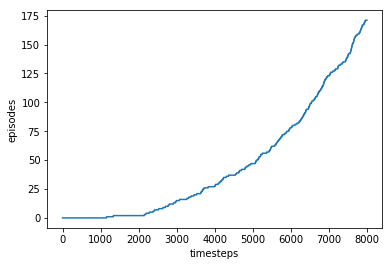

CPU times: user 163 ms, sys: 14 ms, total: 177 ms
Wall time: 177 ms


In [7]:
%%time
q_val, episodes = sarsa(WindyGridworldKingsMovesEnv(noop=True), 8000)
plot_episodes_x_timesteps(episodes)

# Exercício 6.10

In [8]:
class StochasticWindyGridworldEnv(WindyGridworldKingsMovesEnv):
    def step(self, action):
        assert action in self.action_space
        base_wind = self.column_wind[self.state[1]]
        wind = random.choice((-1,0,1)) + base_wind if base_wind else 0
        direction = addt(self.action_effect[action], (-wind, 0))
        result = addt(self.state, direction)
        self.state = state = _clip_to_space(result, self.observation_space)
        
        done = state == self.goal
        return state, -1, done, {}

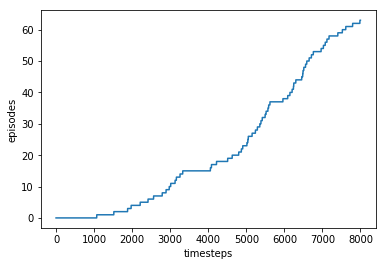

CPU times: user 161 ms, sys: 14.1 ms, total: 175 ms
Wall time: 174 ms


In [9]:
%%time
q_val, episodes = sarsa(StochasticWindyGridworldEnv(), 8000)
plot_episodes_x_timesteps(episodes)